# DaniO5P length model training and evaluation

This notebook trains and evaluates models where all $log_2MRL^{t_i}$ and $Δlog_2X^{t_i - t_{i-1}}$
are functions of quadratic polynomials of the sequence length .

Data is loaded from `../preprocess_data`. Model parameters (polynomial coefficients) are saved to `poly_2_params.pickle` for other notebooks to use, and `length_model_params.csv` in human-readable format. Model predictions and residuals (measurement - predictions, used for training the CNN model later) for all MPRA sequences are saved to `Zb_5UTR_MPRA_len_preds.tsv.gz` and `Zb_5UTR_MPRA_len_residuals.tsv.gz`. Performance metrics ($r^2$) are saved to `length_model_performance_r2.csv`.

In [1]:
import sys

import numpy
import matplotlib
from matplotlib import pyplot
import pickle
import pandas
import scipy
import seaborn

utils_dir = '../utils'
sys.path.append(utils_dir)
import custom_plots

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [3]:
timepoint_list = [2, 4, 6, 10]

lib_tpm_col = 'TPM_library'
log2_lib_tpm_col = 'log2_TPM_library'

log2_mrl_cols = [f'log2_MRL_{t}hpf' for t in timepoint_list]
delta_log2_x_cols = [f'Δlog2_X_{t}hpf' for t in timepoint_list]

In [4]:
# Load data
data_full = pandas.read_csv(
    '../preprocess_data/Zb_5UTR_MPRA_preprocessed.tsv.gz',
    index_col=0,
    sep='\t',
)
max_seq_len = data_full['insert_length'].max()
data_full

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,log2_RRS_HMW_6hpf,log2_RRS_HMW_10hpf,MRL_2hpf,log2_MRL_2hpf,MRL_4hpf,log2_MRL_4hpf,MRL_6hpf,log2_MRL_6hpf,MRL_10hpf,log2_MRL_10hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103.0,103.0,2.0,52.427184,23.9,20318.0,20318,...,-1.691783,-1.551375,5.026628,2.329591,6.713248,2.747011,7.002960,2.807965,6.480393,2.696081
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134.0,134.0,0.0,61.940299,35.3,72681.0,72681,...,-0.488586,-1.978301,5.450300,2.446336,6.196041,2.631347,8.359783,3.063465,4.441558,2.151066
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178.0,178.0,1.0,46.629213,30.1,27446.0,27446,...,-0.519735,-0.728637,5.911159,2.563441,10.441205,3.384216,7.626433,2.931009,6.260806,2.646348
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152.0,152.0,0.0,46.052632,26.1,113092.0,113092,...,0.006799,-0.418159,14.368484,3.844836,12.294140,3.619899,11.405933,3.511713,9.108052,3.187143
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153.0,153.0,1.0,47.058824,31.8,20320.0,20320,...,-0.849952,-2.267783,7.103448,2.828519,6.990700,2.805437,8.646954,3.112192,4.903643,2.293854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000025554_ENSDART00000103273_1746_wdr83os_27060,chr11,+,wdr83os,126.0,126.0,1.0,37.301587,22.8,27060.0,27060,...,-0.684112,1.094197,8.956233,3.162892,13.598507,3.765376,8.083156,3.014919,20.048542,4.325425
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,chr19,+,mrpl3,111.0,111.0,2.0,34.234234,12.5,86762.0,86762,...,-0.736038,-0.117464,11.157909,3.479995,11.045525,3.465390,8.266639,3.047301,12.727341,3.669859
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,chr19,-,znf865,1305.0,197.0,4.0,31.979695,25.9,21263.6,21263,...,0.440297,-1.271031,13.771432,3.783607,19.339298,4.273464,17.089539,4.095042,7.074025,2.822531
ENSDARG00000056892_ENSDART00000148517_5556_mpp6a_23746.2,chr16,-,mpp6a,311.0,161.0,1.0,39.130435,37.6,23746.2,23746,...,0.382270,-0.355217,13.484335,3.753213,14.144042,3.822123,19.909238,4.315366,16.071784,4.006458


Text(0, 0.5, '# sequences')

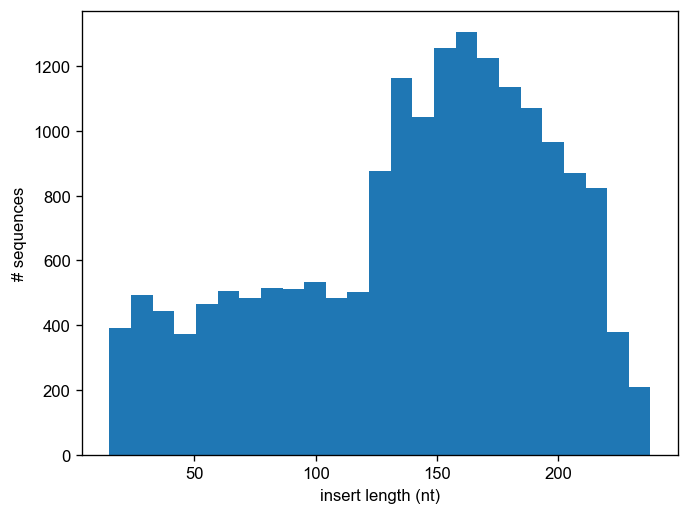

In [5]:
fig, ax = pyplot.subplots()
ax.hist(data_full['insert_length'], bins=25)
ax.set_xlabel('insert length (nt)')
ax.set_ylabel('# sequences')

Text(0, 0.5, 'log2(TPM_library)')

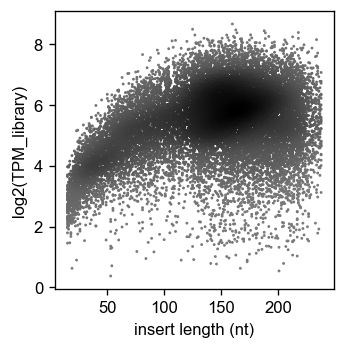

In [6]:
# library TPM vs input length
fig, ax = pyplot.subplots(figsize=(3, 3))
custom_plots.plot_scatter_shaded(
    data_full['insert_length'],
    data_full[f'log2_TPM_library'],
    ax=ax,
)
ax.set_xlabel('insert length (nt)')
ax.set_ylabel('log2(TPM_library)')

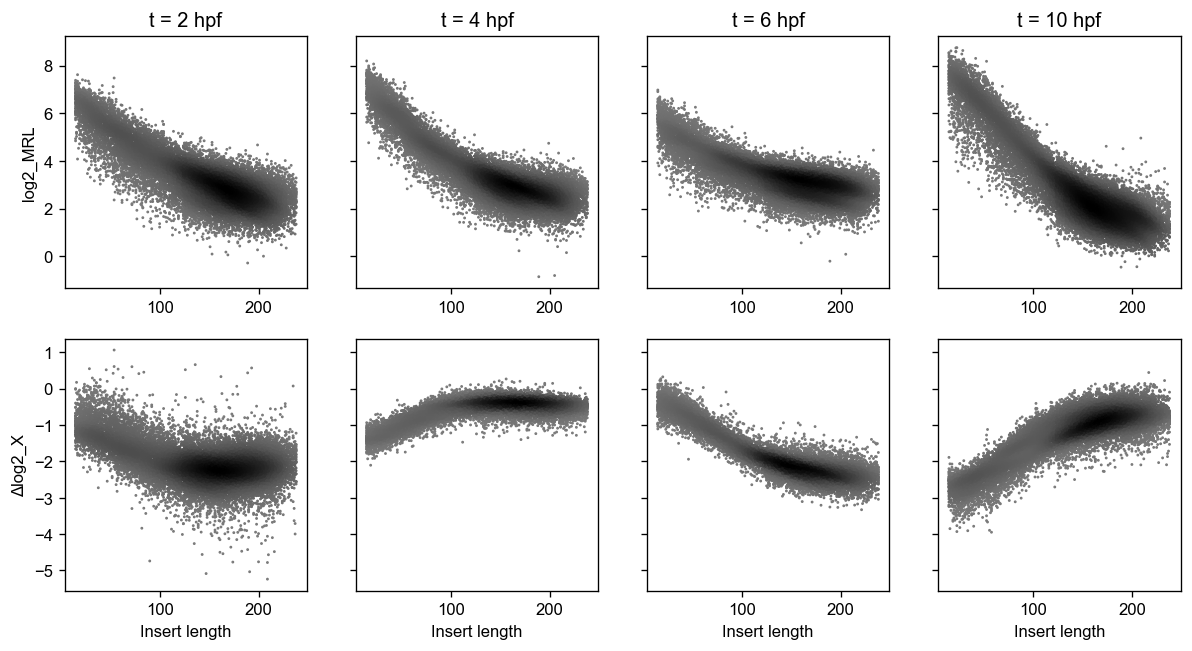

In [7]:
# Plot log2_MRL and delta_log2_TPM_total against insert length
fig, axes = pyplot.subplots(
    2,
    len(timepoint_list),
    figsize=(3*len(timepoint_list), 3*2),
    sharey='row',
)

# Plot log2_MRL
for timepoint_idx, timepoint in enumerate(timepoint_list):
    ax = axes[0, timepoint_idx]
    custom_plots.plot_scatter_shaded(
        data_full['insert_length'],
        data_full[f'log2_MRL_{timepoint}hpf'],
        ax=ax,
    )
    ax.set_title(f"t = {timepoint} hpf")
    # ax.set_xlabel('Insert length')
    if timepoint_idx==0:
        ax.set_ylabel('log2_MRL')

# axes[1, 0].set_visible(False)
for timepoint_idx, timepoint in enumerate(timepoint_list):
    ax = axes[1, timepoint_idx]
    custom_plots.plot_scatter_shaded(
        data_full['insert_length'],
        data_full[f'Δlog2_X_{timepoint}hpf'],
        ax=ax,
    )
    # ax.set_title(f"t = {timepoint} hpf")
    ax.set_xlabel('Insert length')
    if timepoint_idx==0:
        ax.set_ylabel('Δlog2_X')


# Fit model

In [8]:
# Try to fit MRL/deltaX predictor based on length only

# Predictor function
poly_n = 2
def predict_from_seq_len(x, a):
    y_pred = 0
    for i in range(poly_n + 1):
        y_pred += a[i]*(x**i)
    return y_pred

# Residual and initial conditions for fitting
def fit_from_seq_len_residual(a, x, y):
    return y - predict_from_seq_len(x, a)
a_init = [1e-8]*(poly_n + 1)

# Fit length model for each relevant output
length_model_params = {}

for y_idx, ycol in enumerate(log2_mrl_cols + delta_log2_x_cols):
    res_lsq = scipy.optimize.least_squares(
        fit_from_seq_len_residual,
        a_init,
        args=(data_full['insert_length'].values, data_full[ycol].values),
    )
    length_model_params[ycol] = res_lsq['x']

# Save parameters
with open(f'poly_{poly_n}_params.pickle', 'wb') as handle:
    pickle.dump(length_model_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

length_model_params

{'log2_MRL_2hpf': array([ 6.99646357e+00, -4.12189270e-02,  9.22431636e-05]),
 'log2_MRL_4hpf': array([ 7.82440520e+00, -5.16798613e-02,  1.25737802e-04]),
 'log2_MRL_6hpf': array([ 5.92862326e+00, -3.04479625e-02,  7.26491485e-05]),
 'log2_MRL_10hpf': array([ 8.70662460e+00, -6.32159808e-02,  1.35898562e-04]),
 'Δlog2_X_2hpf': array([-4.45053072e-01, -2.22101446e-02,  6.71997889e-05]),
 'Δlog2_X_4hpf': array([-1.68929673e+00,  1.64039512e-02, -5.14284521e-05]),
 'Δlog2_X_6hpf': array([ 1.62845273e-01, -2.35574427e-02,  5.39651336e-05]),
 'Δlog2_X_10hpf': array([-3.47516908e+00,  2.60757058e-02, -6.23094056e-05])}

In [9]:
length_model_params_df = pandas.DataFrame(length_model_params)
length_model_params_df.index = ['a0', 'a1', 'a2']
length_model_params_df.to_csv('length_model_params.csv')
length_model_params_df

,log2_MRL_2hpf,log2_MRL_4hpf,log2_MRL_6hpf,log2_MRL_10hpf,Δlog2_X_2hpf,Δlog2_X_4hpf,Δlog2_X_6hpf,Δlog2_X_10hpf
a0,6.996464,7.824405,5.928623,8.706625,-0.445053,-1.689297,0.162845,-3.475169
a1,-0.041219,-0.051680,-0.030448,-0.063216,-0.022210,0.016404,-0.023557,0.026076
a2,0.000092,0.000126,0.000073,0.000136,0.000067,-0.000051,0.000054,-0.000062


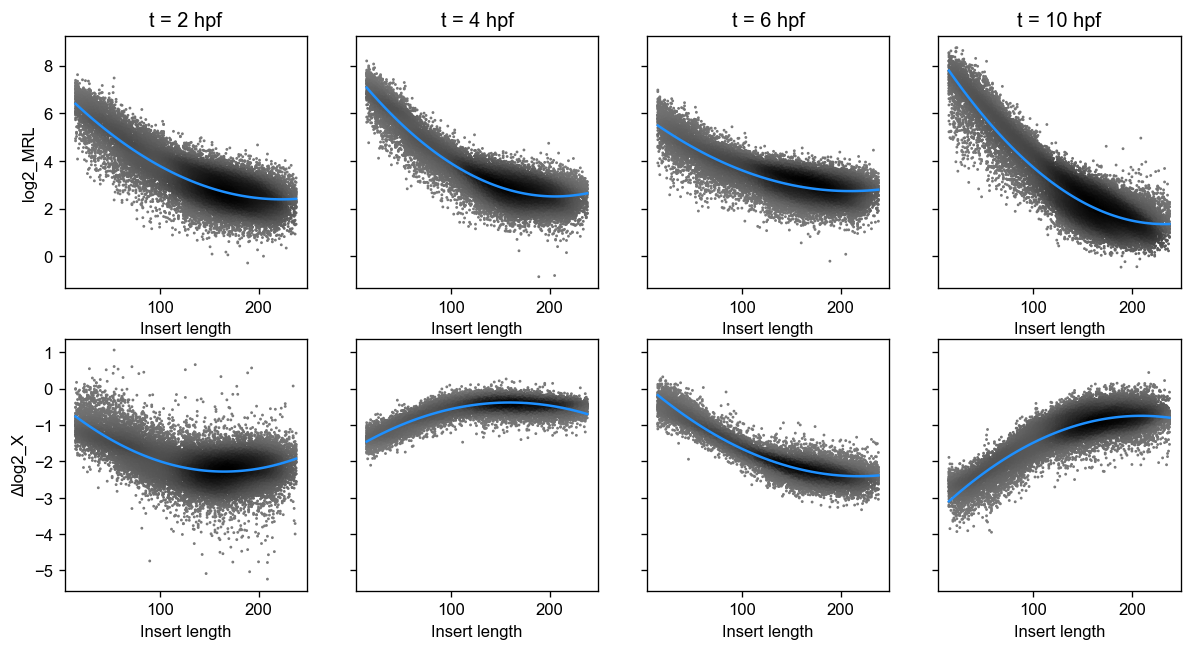

In [10]:
# Plot with predictions
x_fit = numpy.linspace(data_full['insert_length'].min(), data_full['insert_length'].max(), 100)

fig, axes = pyplot.subplots(
    2,
    len(timepoint_list),
    figsize=(3*len(timepoint_list), 3*2),
    sharey='row',
)

# Plot log2_MRL
for timepoint_idx, timepoint in enumerate(timepoint_list):
    ax = axes[0, timepoint_idx]
    custom_plots.plot_scatter_shaded(
        data_full['insert_length'],
        data_full[f'log2_MRL_{timepoint}hpf'],
        ax=ax,
    )
    ax.plot(
        x_fit,
        predict_from_seq_len(x_fit, length_model_params[f'log2_MRL_{timepoint}hpf']),
        color='dodgerblue',
    )
    ax.set_title(f"t = {timepoint} hpf")
    ax.set_xlabel('Insert length')
    if timepoint_idx==0:
        ax.set_ylabel('log2_MRL')

# Plot delta_log2_TPM_total
for timepoint_idx, timepoint in enumerate(timepoint_list):
    ax = axes[1, timepoint_idx]
    custom_plots.plot_scatter_shaded(
        data_full['insert_length'],
        data_full[f'Δlog2_X_{timepoint}hpf'],
        ax=ax,
    )
    ax.plot(
        x_fit,
        predict_from_seq_len(x_fit, length_model_params[f'Δlog2_X_{timepoint}hpf']),
        color='dodgerblue',
    )
    # ax.set_title(f"t = {timepoint} hpf")
    ax.set_xlabel('Insert length')
    if timepoint_idx==0:
        ax.set_ylabel('Δlog2_X')

fig.savefig('measurements_vs_length_with_pred.svg', dpi=200, bbox_inches='tight')
# fig.savefig('measurements_vs_length_with_pred.png', dpi=200, bbox_inches='tight')

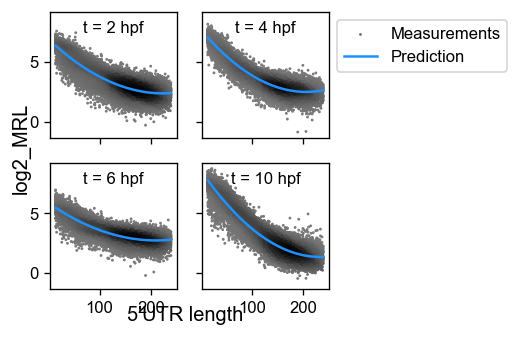

In [11]:
# Plot only MRL in a smaller figure
x_fit = numpy.linspace(data_full['insert_length'].min(), data_full['insert_length'].max(), 100)

fig, axes = pyplot.subplots(
    2,
    len(timepoint_list)//2,
    figsize=(1.5*len(timepoint_list)//2, 1.5*2),
    sharex=True,
    sharey=True,
)

# Plot log2_MRL
for timepoint_idx, timepoint in enumerate(timepoint_list):
    ax = axes[timepoint_idx//2, timepoint_idx%2]
    custom_plots.plot_scatter_shaded(
        data_full['insert_length'],
        data_full[f'log2_MRL_{timepoint}hpf'],
        label='Measurements',
        ax=ax,
    )
    ax.plot(
        x_fit,
        predict_from_seq_len(x_fit, length_model_params[f'log2_MRL_{timepoint}hpf']),
        color='dodgerblue',
        label='Prediction',
    )

    xlim = ax.get_xlim()
    ax.text((xlim[1] + xlim[0])/2, 7.5, f"t = {timepoint} hpf", ha='center')
    
    if (timepoint_idx//2 == 0) and (timepoint_idx%2 == 1):
        ax.legend(bbox_to_anchor=(1, 1))

fig.supxlabel("5'UTR length", )
fig.supylabel('log2_MRL')

fig.savefig('mrl_vs_length_with_pred_small.svg', dpi=200, bbox_inches='tight')
# fig.savefig('mrl_vs_length_with_pred_small.png', dpi=200, bbox_inches='tight')

In [12]:
# Add predictions and residuals to dataframe
for output_name in log2_mrl_cols + delta_log2_x_cols:
    pred_len = predict_from_seq_len(
        data_full['insert_length'].values,
        length_model_params[output_name]
    )
    data_full['pred_len_' + output_name] = pred_len
    data_full['res_' + output_name] = data_full[output_name] - pred_len

{'log2_MRL_2hpf': 0.7001044806009554,
 'log2_MRL_4hpf': 0.8237444243381137,
 'log2_MRL_6hpf': 0.6375606323061519,
 'log2_MRL_10hpf': 0.8492437267156249,
 'Δlog2_MRL_4-2hpf': 0.16251715890888369,
 'Δlog2_MRL_6-2hpf': 0.40037292031360067,
 'Δlog2_MRL_10-2hpf': 0.5116695568011433,
 'Δlog2_X_2hpf': 0.3785354942593437,
 'Δlog2_X_4hpf': 0.6724274420080251,
 'Δlog2_X_6hpf': 0.8622016898023831,
 'Δlog2_X_10hpf': 0.7685451397254239,
 'log2_X_2hpf': 0.3785354942593437,
 'log2_X_4hpf': 0.0550798701881912,
 'log2_X_6hpf': 0.6876375594077243,
 'log2_X_10hpf': 0.019107280524659775}

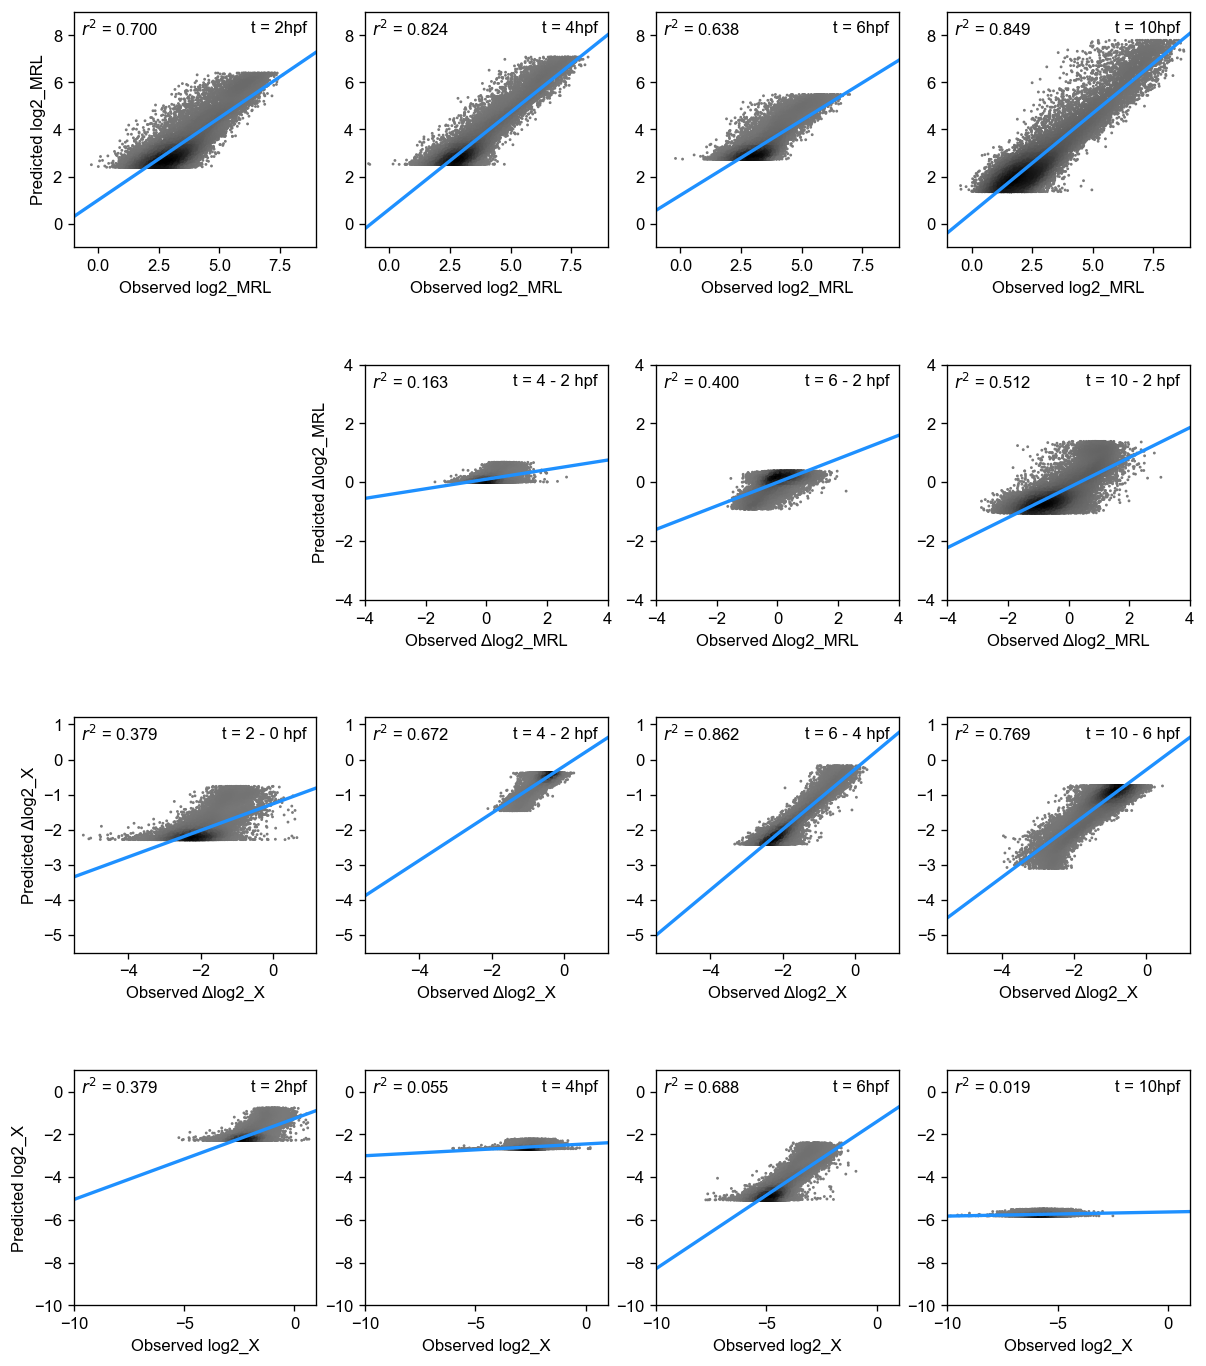

In [13]:
# Plot performance on selected data

# Match what is used in the CNN predictions
min_lib_tpm_thresh = 3
data_to_plot = data_full
data_to_plot = data_to_plot[(data_to_plot[lib_tpm_col] >= min_lib_tpm_thresh)]

# Plot
fig, r2_len_dict = custom_plots.plot_pred_vs_obs(
    data_to_plot,
    obs_col_prefix='',
    pred_col_prefix='pred_len',
    axis_limits=[
        (-1, 9),
        (-4, 4),
        (-5.5, 1.2),
        (-10, 1)
    ],
    return_r2=True,
)
fig.savefig('obs_vs_pred.svg', dpi=200, bbox_inches='tight')
# fig.savefig('obs_vs_pred.png', dpi=200, bbox_inches='tight')

r2_len_dict

In [14]:
# Save performance metrics
r2_len_df = pandas.DataFrame({k: [v] for k, v in r2_len_dict.items()})
r2_len_df.to_csv('length_model_performance_r2.csv')
r2_len_df

,log2_MRL_2hpf,log2_MRL_4hpf,log2_MRL_6hpf,log2_MRL_10hpf,Δlog2_MRL_4-2hpf,Δlog2_MRL_6-2hpf,Δlog2_MRL_10-2hpf,Δlog2_X_2hpf,Δlog2_X_4hpf,Δlog2_X_6hpf,Δlog2_X_10hpf,log2_X_2hpf,log2_X_4hpf,log2_X_6hpf,log2_X_10hpf
0,0.700104,0.823744,0.637561,0.849244,0.162517,0.400373,0.51167,0.378535,0.672427,0.862202,0.768545,0.378535,0.05508,0.687638,0.019107


In [15]:
# Save predictions and residuals
pred_len_cols = [f"pred_len_{output_name}" for output_name in log2_mrl_cols + delta_log2_x_cols]
residual_cols = [f"res_{output_name}" for output_name in log2_mrl_cols + delta_log2_x_cols]

data_full[pred_len_cols].to_csv('Zb_5UTR_MPRA_len_preds.tsv.gz', sep='\t')
data_full[residual_cols].to_csv('Zb_5UTR_MPRA_len_residuals.tsv.gz', sep='\t')